In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer

from pyvi import ViTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### LOAD DATA

In [4]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Đồ án/Code + Data/film_data/film_cleaned_ver2.csv")
df["tokenized_text"] = df["cleaned_text"].apply(
    lambda x: ViTokenizer.tokenize(x)
)
dfML = df[df["label"].isin(
    ["negative", "mixed/neutral", "positive"]
)].copy()
dfML['tokenized_text'].head()

,tokenized_text
0,ta nói nó hài bản_thân tôi con_gái nhưng rất t...
1,hên coi ở cgv phim gì nhân_vật nói chả nghe cá...
2,phim hài cười banh rạp = nửa tiếng đầu mình bi...
3,nếu bỏ tiền mua vé xem phim việt tui tốn chưa ...
4,phim hay ý_nghĩa cười rất nhiều có nhìu hành_đ...


In [ ]:
df.shape

(5409, 10)

#### DICTIONARY

In [5]:
from collections import Counter

In [6]:
vietnamese_stopwords = set([
    "là", "thì", "và", "này", "đó", "một", "với","phim", "không", "nhưng", "được", "có", "mình", "như", "xem", "của", "tôi",
    "con", "thấy", "coi", "người", "quá", "đi","nên", "bộ", "còn", "nhiều", "luôn","cho", "lại", "cái", "vì", "gì", "phần",
    "những", "mọi", "về", "sẽ", "một","phải", "hơn", "các", "rất", "vẫn", "nha", "làm", "đến", "cũng"
])

def top_words_by_label_no_stopwords(df, label, top_n=1000):
    tokens = []

    subset = df[df["label"] == label]["tokenized_text"].dropna()

    for text in subset:
        for token in text.split():
            if token not in vietnamese_stopwords:
                tokens.append(token)

    return Counter(tokens).most_common(top_n)


In [ ]:
labels = ["negative", "mixed/neutral", "positive"]
for lb in labels:
    print(f"\nTop từ (không stopwords) cho nhãn: {lb}")
    for w, c in top_words_by_label_no_stopwords(dfML, lb):
        print(f"{w}: {c}")



Top từ (không stopwords) cho nhãn: negative
dở: 442
hay: 389
tiền: 356
1: 296
nó: 294
chưa: 261
chán: 260
nội_dung: 256
phí: 238
tệ: 236
hiểu: 221
cảnh: 200
lắm: 197
đầu: 189
nói: 184
mấy: 180
-: 180
bị: 179
hết: 174
tới: 167
nhân_vật: 164
cả: 162
từ: 162
ai: 160
rạp: 159
diễn_viên: 154
sao: 151
2: 149
xong: 147
nhạt: 146
rồi: 145
cuối: 143
kết: 142
á: 141
nhất: 140
thất_vọng: 140
chả: 138
ma: 134
chỉ: 133
tình_tiết: 127
diễn: 126
kiểu: 125
hơi: 125
biết: 124
đoạn: 117
kịch_bản: 116
lần: 113
chính: 113
điểm: 112
hài: 107
nói_chung: 106
trước: 104
sợ: 104
thật_sự: 103
thôi: 103
khá: 102
muốn: 101
nhau: 98
ở: 97
mới: 96
khúc: 93
sau: 92
lúc: 92
đừng: 90
đánh_giá: 90
lên: 89
hù: 89
bạn: 88
chê: 86
kinh_dị: 84
3: 83
xàm: 83
đâu: 81
buồn_ngủ: 81
thật: 80
cốt_truyện: 80
thời_gian: 80
rời_rạc: 80
dễ: 79
thoại: 79
vừa: 78
tốn: 77
nữa: 75
sự: 73
tưởng: 71
cứ: 70
khó: 70
nhà: 70
chiếu: 68
10: 67
đoán: 67
chắc: 66
bỏ: 66
toàn: 66
tiếng: 65
nhảm: 65
khác: 65
gây: 63
cười: 63
=: 63
ông: 62
thiếu: 

In [7]:
aspect_dict = {
    "noi_dung_y_nghia": [
        "nội_dung", "ý_nghĩa", "thông_điệp", "truyền_tải", "chủ_đề", "nói_chung"
    ],
    "kich_ban": [
        "kịch_bản", "biên_kịch", "thoại", "kịch_bản_phim","đoạn", "khúc",
        "cốt_truyện", "tình_tiết", "mạch","diễn_biến", "twist", "tình_huống",
        "xây_dựng", "phân_đoạn"
    ],
    "nhan_vat_dien_xuat": [
        "nhân_vật", "diễn_viên", "diễn", "diễn_xuất"
    ],
    "dao_dien": [
        "đạo_diễn", "nhịp", "liên_kết", "thời_lượng"
    ],
    "hinh_anh_ky_xao": [
        "hình_ảnh", "kỹ_xảo", "kĩ_xảo", "góc_quay", "quay_phim","tạo_hình", "trang_phục"
    ],
    "am_thanh": [
        "âm_thanh", "nhạc", "lồng_tiếng"
    ]
}


In [8]:
def detect_aspects(sentence, aspect_dict):
    tokens = sentence.split()
    found = []

    for aspect, keywords in aspect_dict.items():
        for kw in keywords:
            if kw in tokens:
                found.append((aspect, kw))

    return found

In [9]:
def extract_context(sentence, keyword, window=6):
    tokens = sentence.split()
    contexts = []

    for i, tok in enumerate(tokens):
        if tok == keyword:
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            contexts.append(" ".join(tokens[start:end]))

    return contexts

In [10]:
def split_sentences(text):
    return [s.strip() for s in re.split(r"[.!?]", text) if s.strip()]

In [11]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

In [12]:
# Xác định aspect và extract context
records = []

for _, row in dfML.iterrows():
    text = row["tokenized_text"]
    label = row["label"]

    sentences = split_sentences(text)

    for sent in sentences:
        aspects = detect_aspects(sent, aspect_dict)

        for aspect, keyword in aspects:
            contexts = extract_context(sent, keyword)

            for ctx in contexts:
                records.append({
                    "full_sentence": sent,
                    "aspect": aspect,
                    "aspect_keyword": keyword,
                    "aspect_context": ctx,
                    "sentiment_label": label
                })

In [13]:
df_aspect = pd.DataFrame(records)
df_aspect.head()

,full_sentence,aspect,aspect_keyword,aspect_context,sentiment_label
0,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp xiếc khỉ có bao_nhiêu cảnh đi kéo nhau đánh_đấm riết chán hên không rủ bạn_bè coi,nhan_vat_dien_xuat,nhân_vật,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu,negative
1,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp xiếc khỉ có bao_nhiêu cảnh đi kéo nhau đánh_đấm riết chán hên không rủ bạn_bè coi,am_thanh,nhạc,âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp,negative
2,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,nội_dung,không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách,positive
3,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,ý_nghĩa,uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui,positive
4,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,truyền_tải,mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật,positive


In [ ]:
# Xuất file data aspect
df_aspect.to_csv(
    "/content/drive/MyDrive/NLP_Đồ án/Code + Data/film_data/film_aspect.csv",
    index=False,
    encoding="utf-8-sig"
)
print("Số dòng:", len(df_aspect))
df_aspect.head()


Số dòng: 6949


,full_sentence,aspect,aspect_keyword,aspect_context,sentiment_label
0,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp xiếc khỉ có bao_nhiêu cảnh đi kéo nhau đánh_đấm riết chán hên không rủ bạn_bè coi,nhan_vat_dien_xuat,nhân_vật,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu,negative
1,hên coi ở cgv phim gì nhân_vật nói chả nghe cái gì thu âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp xiếc khỉ có bao_nhiêu cảnh đi kéo nhau đánh_đấm riết chán hên không rủ bạn_bè coi,am_thanh,nhạc,âm tiếng người tệ vô_cùng mở nhạc ầm_ầm chói tai như cái rạp,negative
2,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,nội_dung,không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách,positive
3,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,ý_nghĩa,uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui,positive
4,nếu bỏ tiền mua vé xem phim việt tui tốn chưa đầy 3 phim đặc_biệt mấy phim của trấn nước hay của huynh lạp tui thà tốn tiền đi ăn hột vịt lộn uống bia còn thấy đời có ý_nghĩa hơn nhưng truy_tìm long diên_hương tui cảm_thấy xứng_đáng_giá_trị đồng_tiền tui bỏ không phải vì sự xuất_sắc hay nội_dung mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật lời thoại vô_cùng tự_nhiên cách diễn tửng như bản_chất ngoài đời của họ đặc_biệt cảm_giác dễ_chịu nhất diễn_viên rất gần_gũi vì hầu_như không ai can_thiệp thẩm_mỹ tui vẫn nể phục các bạn action c nhất dám nghĩ dám làm chỉ_đạo võ_thuật cực_kì tinh_tế đặc_biệt đoạn đánh roi bình định các rất bình định dù các bạn miền nam nhiều bộ phim võ_thuật bình định các nhà làm phim khác làm tui cứ tưởng đâu võ tàu võ hàn không dù dân bình định đi làm phim bình định phim rất giải_trí giải_quyết nút thắt rất logic không gượng_gạo mọi người nên ủng_hộ món lạ film vn,noi_dung_y_nghia,truyền_tải,mới_mẻ của phim chính vì cách truyền_tải câu_chuyện của phim rất rất thật,positive


#### MACHINE LEARNING

#### TF-IDF TUNING

In [14]:
X = df_aspect["aspect_context"]
y = df_aspect["sentiment_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [15]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_macro = make_scorer(f1_score, average="macro")

In [ ]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [ ]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_features": [10000, 20000, 30000]
}

In [ ]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [10000, 20000, 30000],
                         'tfidf__min_df': [3, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

In [ ]:
df_tfidf_cv = pd.DataFrame(grid.cv_results_)
df_tfidf_cv["ngram"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__ngram_range"])
df_tfidf_cv["min_df"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__min_df"])
df_tfidf_cv["max_features"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__max_features"])
df_tfidf_cv["mean_f1"] = df_tfidf_cv["mean_test_score"]

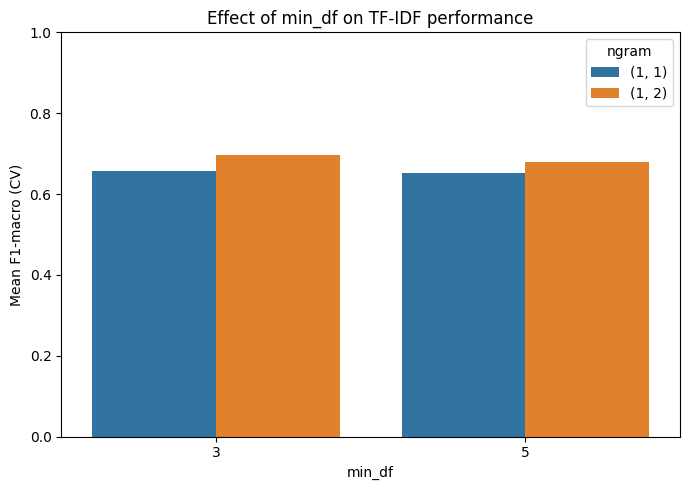

In [ ]:
plt.figure(figsize=(7,5))

sns.barplot(
    data=df_tfidf_cv,
    x="min_df",
    y="mean_f1",
    hue="ngram"
)

plt.xlabel("min_df")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of min_df on TF-IDF performance")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
df_tfidf_cv[
    ["ngram", "min_df", "max_features", "mean_f1", "rank_test_score"]
].sort_values("mean_f1", ascending=False)

,ngram,min_df,max_features,mean_f1,rank_test_score
1,"(1, 2)",3,10000,0.697579,1
5,"(1, 2)",3,20000,0.697579,1
9,"(1, 2)",3,30000,0.697579,1
3,"(1, 2)",5,10000,0.680175,4
11,"(1, 2)",5,30000,0.680175,4
7,"(1, 2)",5,20000,0.680175,4
8,"(1, 1)",3,30000,0.656402,7
0,"(1, 1)",3,10000,0.656402,7
4,"(1, 1)",3,20000,0.656402,7
2,"(1, 1)",5,10000,0.652569,10


In [ ]:
print("TF-IDF TUNING RESULT")
print("Best params:")
print(grid.best_params_)
print("\n Best score:")
print(grid.best_score_)

TF-IDF TUNING RESULT
Best params:
{'tfidf__max_features': 10000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

 Best score:
0.6975791802963264


In [16]:
best_tfidf_params = {
    "ngram_range": (1, 2),
    "min_df": 3,
    "max_features": 10000
}

#### Logistics Regression Tuning

In [17]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": f1_score(y_test, y_pred, average="macro")
    }

In [ ]:
pipe_lr_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

pipe_lr_base.fit(X_train, y_train)

lr_base_result = evaluate_model(pipe_lr_base, X_test, y_test)
lr_base_result

{'Accuracy': 0.7230215827338129, 'F1_macro': 0.7246641140455589}

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    pipe_lr_base,
    param_grid_lr,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        min_df=3,
                                                        ngram_range=(1, 2))),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'],
                         'clf__solver': ['liblinear', 'lbfgs']},
             scoring='f1_macro')

In [ ]:
print(grid_lr.best_estimator_)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, min_df=3,
                                 ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, solver='liblinear'))])
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
0.7124833585689878


In [ ]:
df_lr_cv = pd.DataFrame(grid_lr.cv_results_)

df_lr_cv = df_lr_cv[
    [
        "params",
        "mean_test_score",
        "std_test_score",
        "rank_test_score"
    ]
].sort_values("rank_test_score")

df_lr_cv

,params,mean_test_score,std_test_score,rank_test_score
6,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.712483,0.003277,1
7,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.712340,0.004536,2
5,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.697579,0.007776,3
4,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.687285,0.010229,4
3,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.654281,0.010274,5
2,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.646636,0.010105,6
1,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.631450,0.011780,7
0,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.494250,0.018185,8


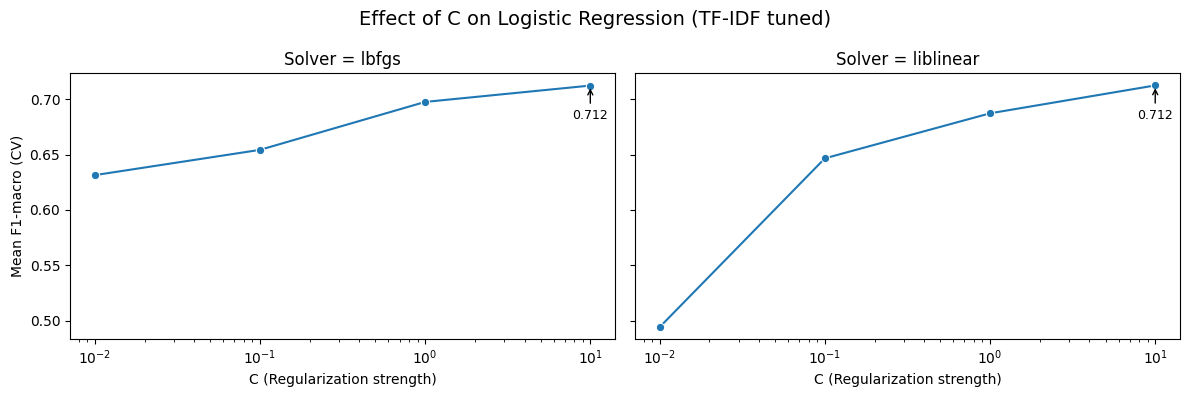

In [ ]:
df_lr_cv["C"] = df_lr_cv["params"].apply(lambda x: x["clf__C"])
df_lr_cv["solver"] = df_lr_cv["params"].apply(lambda x: x["clf__solver"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

solvers = ["lbfgs", "liblinear"]

for ax, solver in zip(axes, solvers):
    data_solver = df_lr_cv[df_lr_cv["solver"] == solver]

    sns.lineplot(
        data=data_solver,
        x="C",
        y="mean_test_score",
        marker="o",
        ax=ax
    )

    ax.set_xscale("log")
    ax.set_title(f"Solver = {solver}")
    ax.set_xlabel("C (Regularization strength)")
    ax.set_ylabel("Mean F1-macro (CV)")

    # ===== ANNOTATE ĐIỂM C = 1 =====
    best_point = data_solver[data_solver["C"] == 10].iloc[0]
    best_c = best_point["C"]
    best_score = best_point["mean_test_score"]

    ax.annotate(
        f"{best_score:.3f}",
        xy=(best_c, best_score),
        xytext=(best_c, best_score - 0.03),
        arrowprops=dict(arrowstyle="->"),
        ha="center",
        fontsize=9
    )

plt.suptitle("Effect of C on Logistic Regression (TF-IDF tuned)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#Thử trên tập test
lr_tuned_result = evaluate_model(
    grid_lr.best_estimator_,
    X_test,
    y_test
)
lr_tuned_result

{'Accuracy': 0.7568345323741007, 'F1_macro': 0.757811951297493}

In [ ]:
df_lr_compare = pd.DataFrame([
    {"Model": "Logistic Regression (baseline)", **lr_base_result},
    {"Model": "Logistic Regression (tuned)", **lr_tuned_result}
])

df_lr_compare

,Model,Accuracy,F1_macro
0,Logistic Regression (baseline),0.723022,0.724664
1,Logistic Regression (tuned),0.756835,0.757812


#### Phân tích ảnh hưởng các các từ (feature)

In [ ]:
# Lấy vectorizer và model từ pipeline
tfidf = pipe_lr_base.named_steps["tfidf"]
clf = pipe_lr_base.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())

coef = clf.coef_
classes = clf.classes_

In [ ]:
top_n = 20

neg_idx = np.where(classes == "negative")[0][0]
top_neg = np.argsort(coef[neg_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_neg],
    "weight": coef[neg_idx][top_neg]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,dở,3.856422
18,chán,2.906791
17,tệ,2.708163
16,không,2.568805
15,tiền,2.328948
14,thất_vọng,2.230524
13,nhạt,2.199034
12,không hay,2.054672
11,phí,1.868847
10,chả,1.787734


In [ ]:
mix_idx = np.where(classes == "mixed/neutral")[0][0]
top_mix = np.argsort(coef[mix_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_mix],
    "weight": coef[mix_idx][top_mix]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,tạm,3.673813
18,nhưng,2.943967
17,ổn,2.678622
16,bình_thường,2.579845
15,hơi,2.573485
14,cũng,2.308260
13,chưa,2.000689
12,giải_trí,1.987077
11,không quá,1.971808
10,thôi,1.844304


In [ ]:
pos_idx = np.where(classes == "positive")[0][0]
top_pos = np.argsort(coef[pos_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_pos],
    "weight": coef[pos_idx][top_pos]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,hay,4.029266
18,phim hay,2.963498
17,cười,2.201209
16,đáng,2.159829
15,rất,2.018785
14,đỉnh,1.887605
13,hài,1.641344
12,đẹp,1.584009
11,tuyệt_vời,1.480602
10,đáng xem,1.474978


#### SVM Tuning

In [ ]:
from sklearn.svm import LinearSVC

pipe_svm_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", LinearSVC(
        class_weight="balanced"
    ))
])

pipe_svm_base.fit(X_train, y_train)

svm_base_result = evaluate_model(pipe_svm_base, X_test, y_test)
svm_base_result

{'Accuracy': 0.758273381294964, 'F1_macro': 0.759280296420517}

In [ ]:
param_grid_svm = {
    "clf__C": [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(
    pipe_svm_base,
    param_grid_svm,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'clf__C': 1}
0.7120283927189586


In [ ]:
df_svm_cv = pd.DataFrame(grid_svm.cv_results_)

df_svm_cv = df_svm_cv[
    [
        "params",
        "mean_test_score",
        "std_test_score",
        "rank_test_score"
    ]
].sort_values("rank_test_score")

df_svm_cv

,params,mean_test_score,std_test_score,rank_test_score
2,{'clf__C': 1},0.712028,0.005678,1
3,{'clf__C': 10},0.697652,0.008774,2
1,{'clf__C': 0.1},0.686531,0.011141,3
0,{'clf__C': 0.01},0.646555,0.010604,4


Text(0.5, 1.0, 'Effect of C on Linear SVM (TF-IDF tuned)')

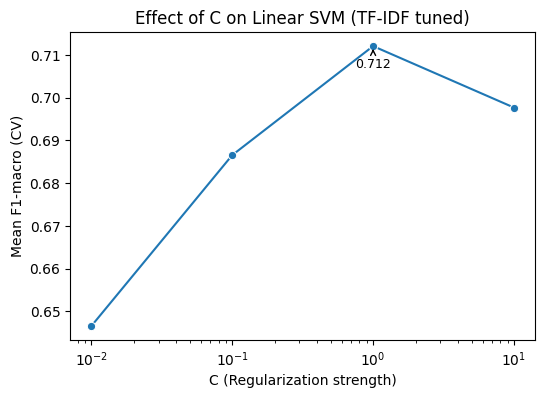

In [ ]:
df_svm_cv["C"] = df_svm_cv["params"].apply(lambda x: x["clf__C"])
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=df_svm_cv,
    x="C",
    y="mean_test_score",
    marker="o"
)

best_point = df_svm_cv.loc[df_svm_cv["mean_test_score"].idxmax()]
best_c = best_point["C"]
best_score = best_point["mean_test_score"]

plt.annotate(
    f"{best_score:.3f}",
    xy=(best_c, best_score),
    xytext=(best_c, best_score - 0.005),
    arrowprops=dict(arrowstyle="->"),
    ha="center",
    fontsize=9
)

plt.xscale("log")
plt.xlabel("C (Regularization strength)")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of C on Linear SVM (TF-IDF tuned)")

In [ ]:
#Thử trên tập test
svm_tuned_result = evaluate_model(
    grid_svm.best_estimator_,
    X_test,
    y_test
)

In [ ]:
df_svm_compare = pd.DataFrame([
    {"Model": "Linear SVM (baseline)", **svm_base_result},
    {"Model": "Linear SVM (tuned)", **svm_tuned_result}
])

df_svm_compare

,Model,Accuracy,F1_macro
0,Linear SVM (baseline),0.758273,0.75928
1,Linear SVM (tuned),0.758273,0.75928


#### Naive Bayes Tuning

In [ ]:
pipe_nb_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", MultinomialNB())
])

pipe_nb_base.fit(X_train, y_train)

nb_base_result = evaluate_model(pipe_nb_base, X_test, y_test)

In [ ]:
param_grid_nb = {
    "clf__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(
    pipe_nb_base,
    param_grid_nb,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)
print(grid_nb.best_score_)

{'clf__alpha': 0.1}
0.7069748263169748


In [ ]:
df_nb_cv = pd.DataFrame(grid_nb.cv_results_)
df_nb_cv["alpha"] = df_nb_cv["params"].apply(lambda x: x["clf__alpha"])

df_nb_table = df_nb_cv[
    ["alpha", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("mean_test_score", ascending=False)

df_nb_table

,alpha,mean_test_score,std_test_score,rank_test_score
0,0.1,0.706975,0.009346,1
1,0.5,0.703773,0.009378,2
2,1.0,0.695626,0.010328,3
3,2.0,0.678173,0.009943,4


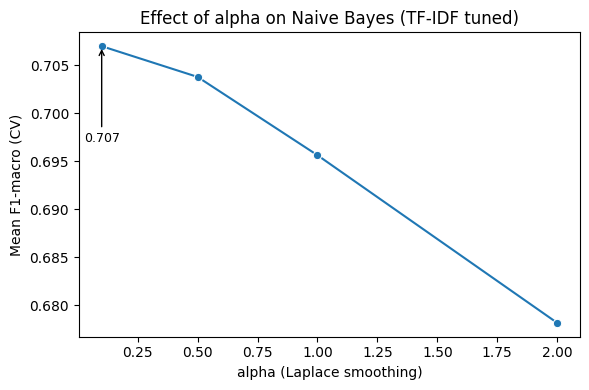

In [ ]:
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=df_nb_cv,
    x="alpha",
    y="mean_test_score",
    marker="o"
)
best_point = df_nb_cv.loc[df_nb_cv["mean_test_score"].idxmax()]
best_alpha = best_point["alpha"]
best_score = best_point["mean_test_score"]

plt.annotate(
    f"{best_score:.3f}",
    xy=(best_alpha, best_score),
    xytext=(best_alpha, best_score - 0.01),
    arrowprops=dict(arrowstyle="->"),
    ha="center",
    fontsize=9
)

plt.xlabel("alpha (Laplace smoothing)")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of alpha on Naive Bayes (TF-IDF tuned)")
plt.tight_layout()
plt.show()

In [ ]:
nb_tuned_result = evaluate_model(
    grid_nb.best_estimator_,
    X_test,
    y_test
)

In [ ]:
df_nb_compare = pd.DataFrame([
    {"Model": "Naive Bayes (baseline)", **nb_base_result},
    {"Model": "Naive Bayes (tuned)", **nb_tuned_result}
])

df_nb_compare

,Model,Accuracy,F1_macro
0,Naive Bayes (baseline),0.702878,0.704495
1,Naive Bayes (tuned),0.734532,0.735707


In [ ]:
df_final = pd.concat([
    df_lr_compare[df_lr_compare["Model"].str.contains("tuned")],
    df_svm_compare[df_svm_compare["Model"].str.contains("tuned")],
    df_nb_compare[df_nb_compare["Model"].str.contains("tuned")]
], ignore_index=True)

df_final.sort_values("F1_macro", ascending=False)

,Model,Accuracy,F1_macro
1,Linear SVM (tuned),0.758273,0.759280
0,Logistic Regression (tuned),0.756835,0.757812
2,Naive Bayes (tuned),0.734532,0.735707


In [ ]:
df_final_compare = pd.DataFrame([
    {"Model": "Logistic Regression", "Setting": "Baseline", **lr_base_result},
    {"Model": "Logistic Regression", "Setting": "Tuned",    **lr_tuned_result},

    {"Model": "Linear SVM", "Setting": "Baseline", **svm_base_result},
    {"Model": "Linear SVM", "Setting": "Tuned",    **svm_tuned_result},

    {"Model": "Naive Bayes", "Setting": "Baseline", **nb_base_result},
    {"Model": "Naive Bayes", "Setting": "Tuned",    **nb_tuned_result},
])

df_final_compare.sort_values("F1_macro", ascending=False).reset_index(drop=True)

,Model,Setting,Accuracy,F1_macro
0,Linear SVM,Tuned,0.758273,0.759280
1,Linear SVM,Baseline,0.758273,0.759280
2,Logistic Regression,Tuned,0.756835,0.757812
3,Naive Bayes,Tuned,0.734532,0.735707
4,Logistic Regression,Baseline,0.723022,0.724664
5,Naive Bayes,Baseline,0.702878,0.704495


#### Xuất model tốt nhất

In [ ]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# lưu model
joblib.dump(pipe_svm_base, "models/svm_absa_model.joblib")

print("Model đã được lưu tại: models/svm_absa_model.joblib")


#### VISUALIZATION EXAMPLE

In [ ]:
def predict_absa(text, model, aspect_dict, window=6):
    tokenized_text = ViTokenizer.tokenize(text)
    sentences = split_sentences(tokenized_text)
    results = []

    for sent in sentences:
        aspects = detect_aspects(sent, aspect_dict)

        for aspect, keyword in aspects:
            contexts = extract_context(sent, keyword, window)

            for ctx in contexts:
                pred = model.predict([ctx])[0]

                results.append({
                    "sentence": sent,
                    "aspect": aspect,
                    "keyword": keyword,
                    "context": ctx,
                    "predicted_sentiment": pred
                })

    return results

In [ ]:
import joblib

model = joblib.load("models/svm_absa_model.joblib")

print("Model đã load xong")

In [ ]:
aspect_dict = {
    "noi_dung_y_nghia": [
        "nội_dung", "ý_nghĩa", "thông_điệp", "truyền_tải", "chủ_đề", "nói_chung"
    ],
    "kich_ban": [
        "kịch_bản", "biên_kịch", "thoại", "kịch_bản_phim","đoạn", "khúc",
        "cốt_truyện", "tình_tiết", "mạch","diễn_biến", "twist", "tình_huống",
        "xây_dựng", "phân_đoạn"
    ],
    "nhan_vat_dien_xuat": [
        "nhân_vật", "diễn_viên", "diễn", "diễn_xuất"
    ],
    "dao_dien": [
        "đạo_diễn", "nhịp", "liên_kết", "thời_lượng"
    ],
    "hinh_anh_ky_xao": [
        "hình_ảnh", "kỹ_xảo", "kĩ_xảo", "góc_quay", "quay_phim","tạo_hình", "trang_phục"
    ],
    "am_thanh": [
        "âm_thanh", "nhạc", "lồng_tiếng"
    ]
}

In [ ]:
raw_text = """Xây dựng nhân vật như kiểu không não luôn"""
model = pipe_svm_base

results = predict_absa(
    tokenized_text,
    model,
    aspect_dict
)
for i, r in enumerate(results, 1):
    print("="*90)
    print(f"[{i}] SENTENCE : {r['sentence']}")
    print(f"    ASPECT   : {r['aspect']}")
    print(f"    KEYWORD  : {r['keyword']}")
    print(f"    CONTEXT  : {r['context']}")
    print(f"    SENTIMENT: {r['predicted_sentiment']}")

[1] SENTENCE : Xây_dựng nhân_vật như kiểu không não luôn
    ASPECT   : nhan_vat_dien_xuat
    KEYWORD  : nhân_vật
    CONTEXT  : Xây_dựng nhân_vật như kiểu không não luôn
    SENTIMENT: negative
